pa:260
length of pv_slice:220
spacing of pvs:15


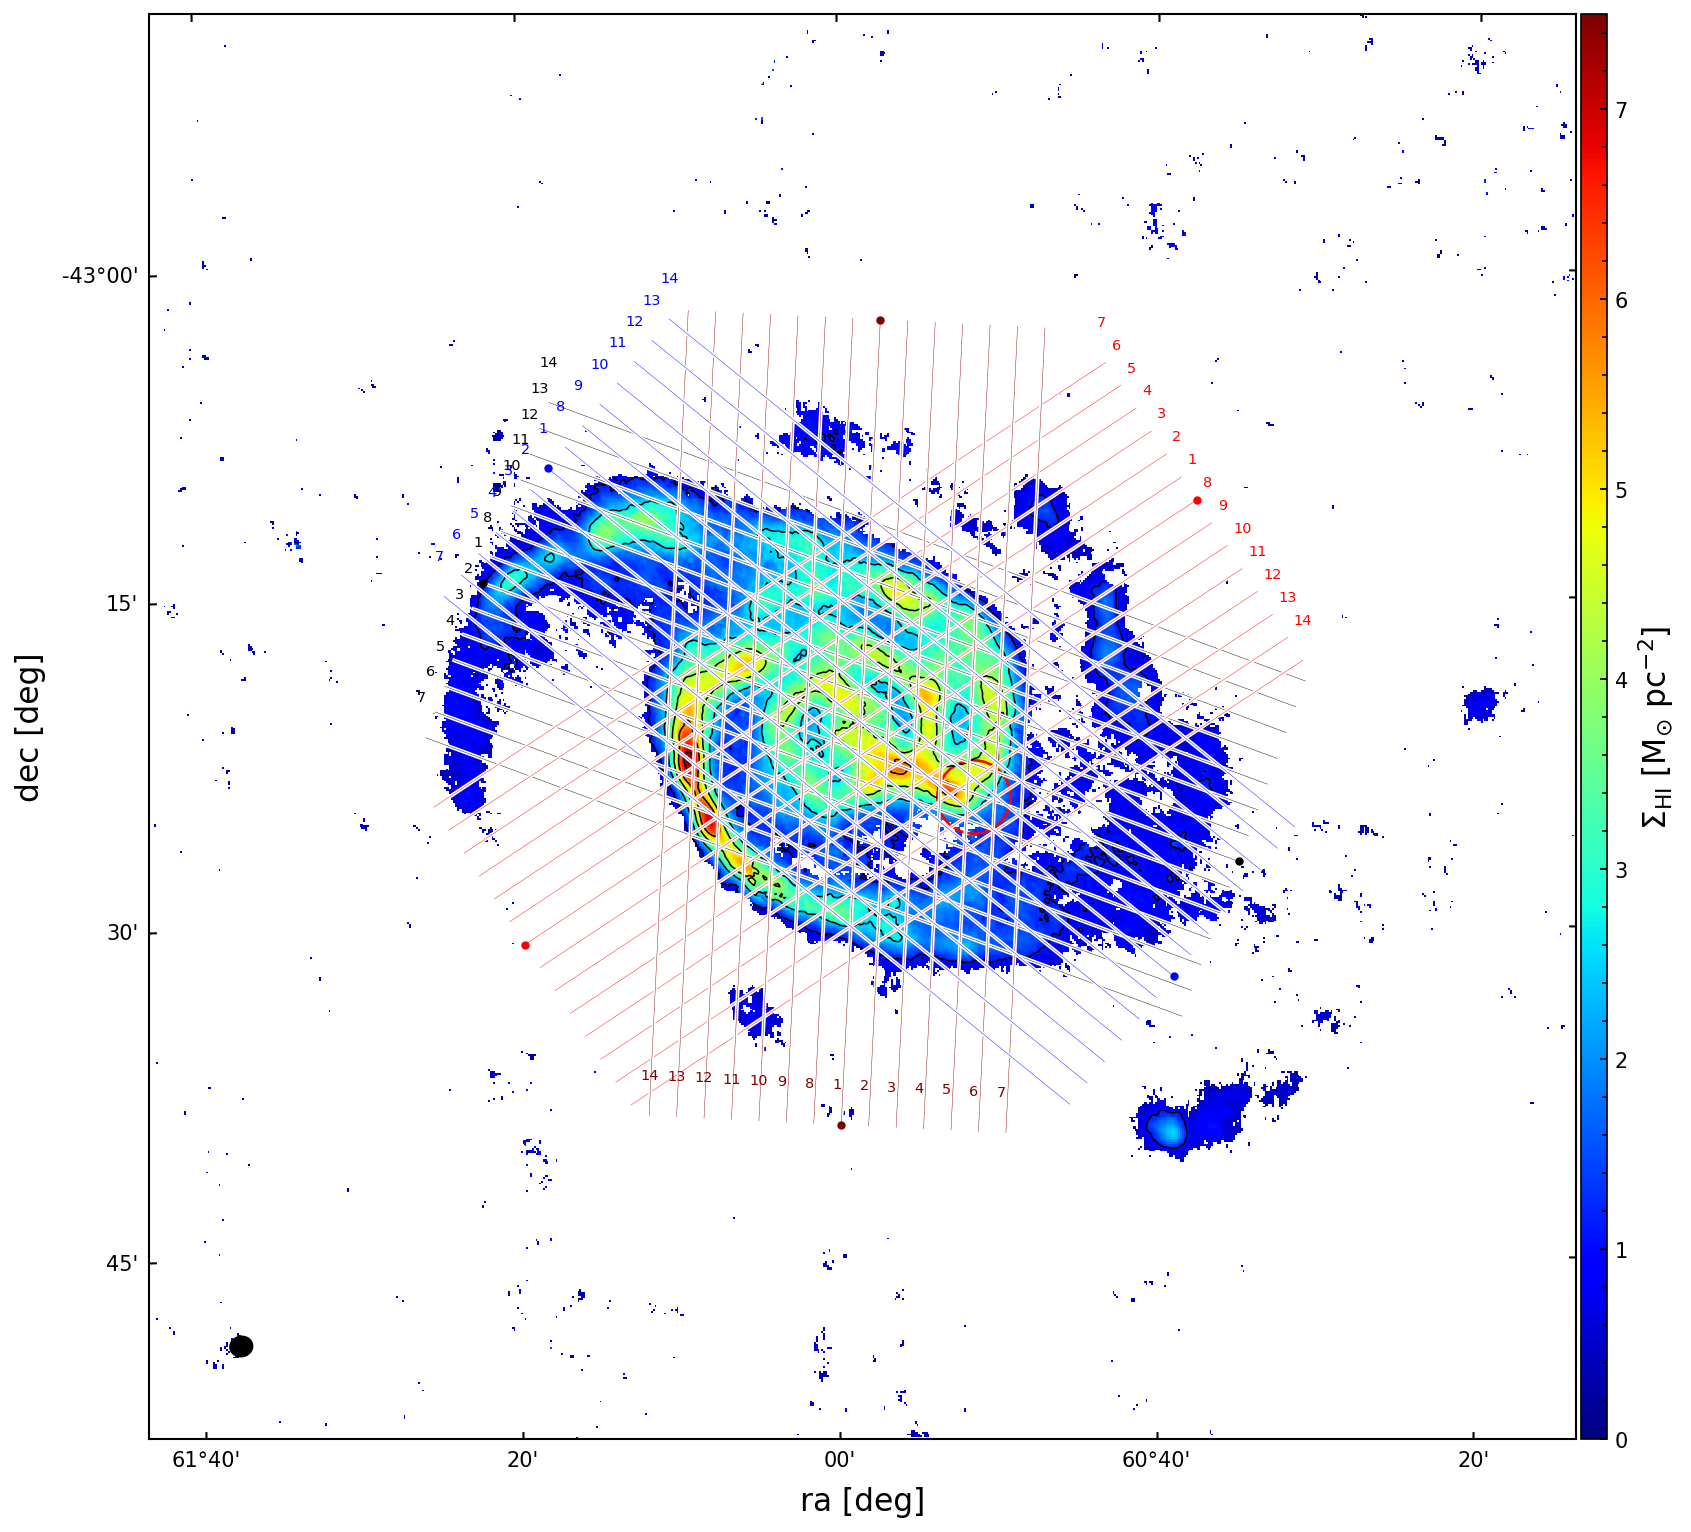

In [1]:
import numpy as np
import pylab as pl
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import matplotlib as mpl
from matplotlib.patches import Ellipse
import pvextractor as pv_ex
from spectral_cube import SpectralCube
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] =  True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True


pa = np.degrees(float(input('pa:')))                                #position angle along to extract pv_slice from 3dBarolo
l = float(input('length of pv_slice:'))                 #length of the pv slice
N = float(input('spacing of pvs:'))                     #distance between pvs in pix

HI_map = fits.open('ATCA_intens_map_3cons_herm.fits')               #opening the HI map of N1512/10
atca_cube = fits.open('ngc1512.line.4km.na.icln.fits')              #reading the atca cube


model = fits.open('current_model.fits')          #current model
K08 = fits.open('K08_model.fits')                #reading the k08 model 

rms_model = 0.00625                                             #cmin from the model]
rms_noise = np.std(atca_cube[0].data[0,4,:,:])

x_c, y_c = 388.22, 390.81                                        #Barolo center

data = HI_map[0].data                           #data extraction
wcs = WCS(HI_map[0].header).celestial           #passing the WCS object 

#.............................coverting_map_units......................................

pix_size = 4.             #pixel scale in arcsec
pix_area = pix_size**2.    #pixel area
bmaj = HI_map[0].header['BMAJ']*3600   #primary beam major axis
bmin = HI_map[0].header['BMIN']*3600    #primary minor axis

beam_area = 1.134*bmaj*bmin               #calculating the beam area
n_pix = beam_area/pix_area                #number of pixels per beam

pix_scale = (pix_size/206265.)*9.5*1e+6   #pixel scale in parsecs -- careful of distance
phy_area = pix_scale**2.

Jy_kms = HI_map[0].data/(n_pix)    #map in Jy km/s

M_HI = (2.36e5)*(9.5**2.)*Jy_kms     #HI mass 
surface_dens = M_HI/phy_area                #surface density in solM/pc^2
surface_dens[np.where(surface_dens == 0.)] = np.nan   #blanking all the zero values.

pl.subplot(projection = wcs)
pl.imshow(surface_dens, origin = 'lower', cmap = 'jet', vmin = 0, vmax = 7.5)
ax = pl.gca()
ax.add_patch(Ellipse((50, 50), HI_map[0].header['bmaj']/HI_map[0].header['cdelt1'], 
    HI_map[0].header['bmin']/HI_map[0].header['cdelt1'], angle = HI_map[0].header['bpa'],  linewidth = 0.75, edgecolor = 'k', facecolor = 'k'))
ax.add_patch(Ellipse((450, 350), 40, 40, linewidth = 1.25, edgecolor = 'red', fill = False))
#ax.add_patch(Ellipse((388.21, 390.84), 2*480/4, 2*220.22/4, angle = 350, linewidth = 0.75,
    #                          edgecolor = 'maroon', fill = False, ls = '-'))
cb = pl.colorbar(fraction = 0.039, aspect = 55, pad = .003)
cb.ax.tick_params(axis = 'y', which = 'minor', direction = 'in', length = 2.5, width = .8)
cb.set_label(label = r'$\Sigma_{\rm HI}$ [M$_{\odot}$ pc$^{-2}$]', size = 15)
pl.contour(surface_dens, linewidths = 0.75, levels = np.arange(1.1, 10, 1.5), colors = 'k')
pl.plot(x_c, y_c, marker = 'x', color = 'r')
pl.xlabel('ra [deg]', fontsize = 15)
pl.ylabel('dec [deg]', fontsize = 15)

#..............................considering_half_of_the_triangle............................

colors = ['k', 'r', 'maroon', 'b']    #different colors for clarity

pvs_d = [[[] for _ in range(7)] for _ in range(4)]  #for storing pixel position of each path below the main pv_slice.
pvs_u = [[[] for _ in range(7)] for _ in range(4)]  #\\ \\ \\ \\ \\ on top of the main pv_slice.




for j in range(4):                     #looping over different angles relative to the pa
 
    theta = 360 - pa                    
    alpha = theta - 90                          #from calculations

    side_1_h = l*np.cos(alpha)      #one side of the RAT

    x_2 = x_c + side_1_h                        #the x-coordinate at angle alpha of the RAT

    side_2_h = l*np.sin(alpha)

    y_2 = y_c - side_2_h                      #the y-coordinate at angle alpha of the RAT

    #....................now_checking_the_full_triangle..................................

    side_1_f = 2*l*np.sin(alpha)      #opposite side of the full triangle

    y_1 = y_2 + side_1_f                           #y-coordinate of the full triangle

    side_2_f = 2*l*np.cos(alpha)       #adjacent side of the full triangle

    x_1 = x_2 - side_2_f                           #x-coordinate of the full triangle

    #.....................now_the_very_small_triangle....................................

    beta = theta - 90                               #from calculations

    d_y = N*np.cos(beta)               #adjacent side of the very_small triangle

    y_r = y_c - d_y                                  #the y-coordinate of the very_small triangle from distance formula

    d_x = N*np.sin(beta)                #opposite side of the very_small triangle

    x_r = x_c - d_x                                  #the y-coordinate of the v_small triangle from distance formula

    x_shift = x_c - x_r                              #for shifting all the x-coordinates
    y_shift = y_c - y_r                              #for shifting all the y-coordinates

    
    for i in range(len(pvs_d[0])):

        pvs_d[j][i].append((x_1, y_1))
        pvs_d[j][i].append((x_2, y_2))
        
        pl.plot((x_1, x_2), (y_1, y_2), ls = '-', color = 'white', linewidth = 1.8)
        pl.plot((x_1, x_2), (y_1, y_2), ls = '-', color = colors[j], linewidth = .2)
        
        #..............................numbering the pv_slices.................................
        
        if pa == 260:
            pl.text(x_1 - 15, y_1- 500, str(i + 1), color = colors[j], fontdict = {'size': 'x-small'}, rotation = 25)
            
        elif pa == 260 - 45:
            pl.text(x_1 + 15, y_1 - 10, str(i + 1), color = colors[j], fontdict = {'size': 'x-small'})
            
        elif pa == 260 - 90:
            pl.text(x_1 - 30, y_1 - 100, str(i + 1), color = colors[j], fontdict = {'size': 'x-small'})
        
        else:
            pl.text(x_1 - 5, y_1 + 20, str(i + 1), color = colors[j], fontdict = {'size': 'x-small'})
    
     #..............................numbering the pv_slices.................................



        if i == 0:
            pl.plot(x_1, y_1, marker = '.', color = colors[j])
            pl.plot(x_2, y_2, marker = '.', color = colors[j])

        x_1, y_1 = x_1 - x_shift, y_1 - y_shift
        x_2, y_2 = x_2 - x_shift, y_2 - y_shift

    #..................................for_upper_pvs................................................

    x_2 = x_c + side_1_h                        #the x-coordinate at angle alpha of the RAT
    y_2 = y_c - side_2_h                      #the y-coordinate at angle alpha of the RAT

    x_1 = x_2 - side_2_f                           #x-coordinate of the full triangle
    y_1 = y_2 + side_1_f                           #y-coordinate of the full triangle


    for i in range(len(pvs_u[0])):
        
        x_1, y_1 = x_1 + x_shift, y_1 + y_shift
        x_2, y_2 = x_2 + x_shift, y_2 + y_shift

        pvs_u[j][i].append((x_1, y_1))
        pvs_u[j][i].append((x_2, y_2))
        
        pl.plot((x_1, x_2), (y_1, y_2), ls = '-', color = 'white', linewidth = 1.8)
        pl.plot((x_1, x_2), (y_1, y_2), ls = '-', color = colors[j], linewidth = .2)
        
        #..............................numbering the pv_slices.................................
        
        if pa == 260:
            pl.text(x_1 - 15, y_1 - 500, str(i + 1 + 7), color = colors[j], fontdict = {'size': 'x-small'}, rotation = 25)
            
        elif pa == 260 - 45:
            pl.text(x_1 + 15, y_1 - 10, str(i + 1 + 7), color = colors[j], fontdict = {'size': 'x-small'})
            
        elif pa == 260 - 90:
            pl.text(x_1 - 30, y_1 - 20, str(i + 1 + 7), color = colors[j], fontdict = {'size': 'x-small'})
        
        else:
            pl.text(x_1 - 5, y_1 + 20, str(i + 1 + 7), color = colors[j], fontdict = {'size': 'x-small'})
    
    #..............................numbering the pv_slices.................................


            
        
    pa = pa - np.degrees(45)                              #extracting at angles n*45 deg relative to pa

pl.subplots_adjust(right = 2.3, top = 2.5, hspace = 0.3, wspace = 0.5)
pl.savefig('pv_extract.png', format = 'png', bbox_inches = 'tight', dpi = 150)
pl.show()

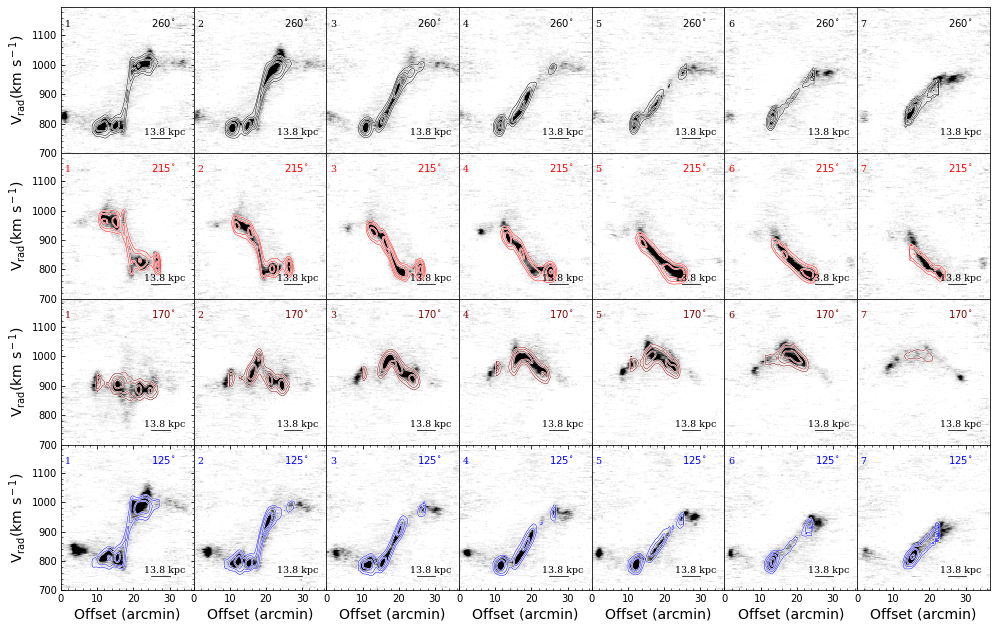

In [3]:
r, V_pv = np.loadtxt('pv_velocities.txt', unpack = True)
pa_s = [260, 215, 170, 125]

fig, ax = pl.subplots(nrows = len(pvs_d), ncols = len(pvs_d[0]), figsize = (12, 12))

for j in range(len(pvs_d)):
    for i in range(len(pvs_d[0])):

        p = pv_ex.Path(pvs_d[j][i], width = 15*u.arcsec)
        slice_data = pv_ex.extract_pv_slice(atca_cube[0].data[0, : , :, :], p, wcs = WCS(atca_cube[0].header))               #extracting slice from the data
        slice_model = pv_ex.extract_pv_slice(model[0].data[:, :, :], p, wcs = WCS(atca_cube[0].header))                  #extracting slice from the model
        #ax[j, i].plot(r + 18.3, V_pv*np.sin(np.deg2rad(51)) + 898, 'r.',)
        ax[j, i].imshow(slice_data.data, origin = 'lower',vmin = -0.02*rms_noise, vmax = 10*rms_noise, cmap = 'Greys', aspect = 'auto', interpolation = None, extent = [0, 10*l/60, 700, 1196])           #image
        ax[j, i].contour(slice_model.data, levels = (2**np.arange(8))*rms_model, linewidths = 1.7, colors = 'white', extent = [0, 10*l/60, 700, 1196])  #model contours
        ax[j, i].contour(slice_model.data, levels = (2**np.arange(8))*rms_model, linewidths = .5, colors = colors[j], extent = [0, 10*l/60, 700, 1196])  #model contours
        ax[j, i].text(25, 1130, str(pa_s[j])+r'$^{\circ}$', color = colors[j])
        ax[j, i].plot((25, 30), (750, 750), 'k-', linewidth = .75)
        ax[j, i].text(23, 760, r'13.8 kpc', fontsize = 9.5, fontdict = dict(family = 'serif', size = 'x-small'))
        ax[j, i].text(1, 1130, (str(i + 1)), color = colors[j], fontsize = 9.5, fontdict = dict(family = 'serif', size = 'x-small'))
        
        if i != 0 :
            ax[j, i].yaxis.set_visible(False)   #blanking y_ticks
            
        if j == 0 or j == 1 or j == 2:
            ax[j, i].xaxis.set_visible(False)    #blanking x_ticks
            
        if i == 0:
            ax[j, i].set_ylabel(r'$\rm V_{\rm rad} (\rm km\ s^{\rm -1})$', fontsize = 14)

        if j == 3:   #labelling the last three plots
            ax[j, i].set_xlabel('Offset (arcmin)', fontsize = 14)

fig.subplots_adjust(right = 1.2, top = .8, wspace = 0.0, hspace = 0.0)
pl.savefig('upper_pv_slices.png', format = 'png', bbox_inches = 'tight', dpi = 150)
pl.show()

/Users/xoks/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


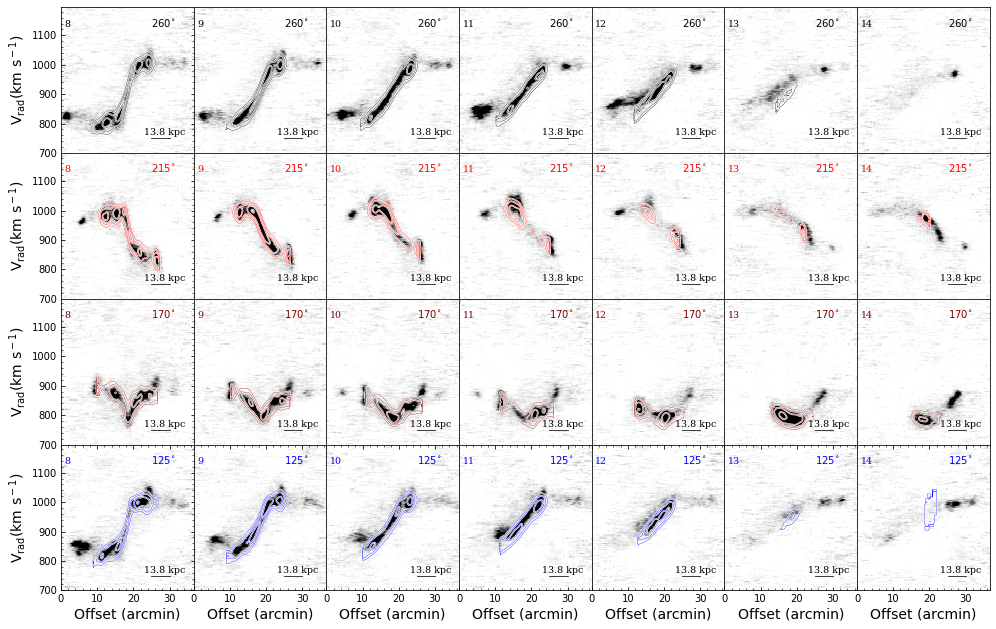

In [5]:
#..........................plotting_pvs_under_the_main_one......................................

pa_s = [260, 215, 170, 125]

fig, ax = pl.subplots(nrows = len(pvs_u), ncols = len(pvs_u[0]), figsize = (12, 12))

for j in range(len(pvs_u)):
    for i in range(len(pvs_u[0])):

        p = pv_ex.Path(pvs_u[j][i], width = 15*u.arcsec)
        slice_data = pv_ex.extract_pv_slice(atca_cube[0].data[0, : , :, :], p, wcs = WCS(atca_cube[0].header))               #extracting slice from the data
        slice_model = pv_ex.extract_pv_slice(model[0].data[:, :, :], p, wcs = WCS(atca_cube[0].header))                  #extracting slice from the model

        ax[j, i].imshow(slice_data.data, origin = 'lower', vmin = -0.02*rms_noise, vmax = 10*rms_noise, cmap = 'Greys', aspect = 'auto', interpolation = None, extent = [0, 10*l/60, 700, 1196])           #image
        ax[j, i].contour(slice_model.data, levels = (2**np.arange(8))*rms_model, linewidths = 1.7, colors = 'white', extent = [0, 10*l/60, 700, 1196])  #model contours
        ax[j, i].contour(slice_model.data, levels = (2**np.arange(8))*rms_model, linewidths = .35, colors = colors[j], extent = [0, 10*l/60, 700, 1196])  #model contours
        ax[j, i].text(25, 1130, str(pa_s[j])+r'$^{\circ}$', color = colors[j])
        ax[j, i].plot((25, 30), (750, 750), 'k-', linewidth = .75)
        ax[j, i].text(23, 760, r'13.8 kpc', fontsize = 9.5, fontdict = dict(family = 'serif', size = 'x-small'))
        ax[j, i].text(1, 1130, (str(i + 1 + 7)), color = colors[j], fontsize = 9.5, fontdict = dict(family = 'serif', size = 'x-small'))
        
        if i != 0 :
            ax[j, i].yaxis.set_visible(False)   #blanking y_ticks
            
        if j == 0 or j == 1 or j == 2:
            ax[j, i].xaxis.set_visible(False)    #blanking x_ticks
            
        if i == 0:
            ax[j, i].set_ylabel(r'$\rm V_{\rm rad} (\rm km\ s^{\rm -1})$', fontsize = 14)

        if j == 3:   #labelling the last three plots
            ax[j, i].set_xlabel('Offset (arcmin)', fontsize = 14)

fig.subplots_adjust(right = 1.2, top = .8, wspace = 0.0, hspace = 0.0)
pl.savefig('lower_pv_slices.png', format = 'png', bbox_inches = 'tight', dpi = 150)
pl.show()